# <center>+++ Project is currently in progress ;-) +++<center>

# Principal component analysis on MNIST

In this notebook, I apply **principal component analysis (PCA)** on the MNIST data set of handwritten digits. The goal of this project is to examine how a reduction in features impacts the accuracy of a classifier.

## 1. Set up the notebook and load the MNIST data

In contrary to previous projects I will work with the entire MNIST dataset for this project

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

In [2]:
# Get data from csv files
train_images = np.loadtxt("MNIST/mnist_train.csv", delimiter=",")
test_images = np.loadtxt("MNIST/mnist_test.csv", delimiter=",")

In [3]:
print(np.shape(train_images))
print(np.shape(test_images))

(60000, 785)
(10000, 785)


In [4]:
train_data = train_images[:,1:]
train_labels = train_images[:,:1]
test_data = test_images[:,1:]
test_labels = test_images[:,:1]

print('Shape of training data: {}'.format(np.shape(train_data)))
print('Shape of training labels: {}'.format(np.shape(train_labels)))
print('Shape of test data: {}'.format(np.shape(test_data)))
print('Shape of test labels: {}'.format(np.shape(test_labels)))

Shape of training data: (60000, 784)
Shape of training labels: (60000, 1)
Shape of test data: (10000, 784)
Shape of test labels: (10000, 1)


# 2. Statistics

In principal component analysis the first eigenvectors of the covariance matrix of the data indicate the directions of the highest variance. These directions can be interpreted as the projected features of the data that contain the most information.

* *The ith **diagonal entry** of the covariance is the variance in the ith coordinate (the ith pixel).*
* *The ith **eigenvalue** of the covariance matrix is the variance in the direction of the ith eigenvector.*

In [5]:
# Compute covariance matrix
sigma = np.cov(train_data, rowvar=0, bias=1)
# Compute coordinate-wise variances, in increasing order
coordinate_variances = np.sort(sigma.diagonal())
# Compute variances in eigenvector directions
eigenvector_variances = np.sort(np.linalg.eigvalsh(sigma))

In [6]:
print('Highest variances \n\nin coordinate direction \tin eigenvector direction')
[print('{}\t\t\t\t{}'.format(coord, eig)) \
     for coord, eig in zip(np.round(coordinate_variances[::-1][:10], 0), np.rint(eigenvector_variances[::-1][:10]))];

Highest variances 

in coordinate direction 	in eigenvector direction
12953.0				332719.0
12934.0				243280.0
12752.0				211504.0
12736.0				184773.0
12689.0				166924.0
12682.0				147842.0
12682.0				112176.0
12680.0				98873.0
12645.0				94695.0
12629.0				80808.0


The highest variances in eigenvector directions are significantly higher than the highest variances in the directions of the image pixel coordinates. This shows that the **first eigenvector directions contain more information** than any of the image pixel coordinates.

Another observation is, that the variances in the eigenvector directions decrease rapidly. Let's plot this to make this even clearer.

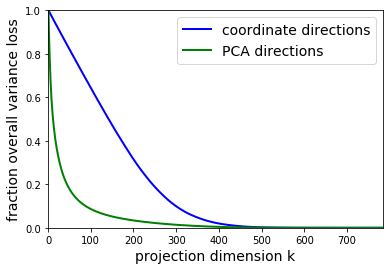

In [19]:
# Compute fraction of overall variance loss when projecting to k coordinate directions
cum_coordinate_variances = np.cumsum(coordinate_variances)
fract_cum_coord_variances = cum_coordinate_variances / cum_coordinate_variances[len(cum_coordinate_variances)-1]
# Compute fraction of overall variance loss when projecting to k eigenvector directions
cum_eigenvector_variances = np.cumsum(eigenvector_variances)
fract_cum_eigvec_variances = cum_eigenvector_variances / cum_eigenvector_variances[len(cum_eigenvector_variances)-1]
# Plot results
plt.plot(np.arange(1, 784), fract_cum_coord_variances[784:0:-1], 'b-', lw=2)
plt.plot(np.arange(1, 784), fract_cum_eigvec_variances[784:0:-1], 'g-', lw=2)
plt.xlabel('projection dimension k', fontsize=14)
plt.ylabel('fraction overall variance loss', fontsize=14)
plt.xlim(0, 784)
plt.ylim(0.0, 1.0)
plt.legend(['coordinate directions', 'PCA directions'], fontsize=14);

# 3. Projection and reconstruction

To get a clearer feeling of how the reduction in dimensionality using PCA and the loss in variance is actually reflected in the images, some examples are shown. The steps for PCA projection to *k* dimensions are:
1. **Projection** of original handwritten digit from 784-dimensional space down to *k* dimensions
2. **Reconstruction** of of image from projected *k* dimensions to 784-dimensional space

The data of the image gets projected from the 784-dimensional space to the *k* directions of the eigenvectors *u_1,...,u_k* with the highest eigenvalue. These are the directions with the highest variance. The projection of an image x is calculated as follows:

$$(x \cdot u_1, x \cdot u_2, ... x \cdot u_k) = U^Tx$$

The image is reconstructed from the projection by multiplying the projection with the eigenvectors *u_1,...,u_k*. So the projection and reconstruction combined for an image x is calculated as follows:

$$(x \cdot u_1)u_1 + (x \cdot u_2)u_2 + ... + (x \cdot u_k)u_k = UU^Tx$$

In [23]:
# Compute eigenvalues and eigenvectors from covariance matrix sigma
eigenvalues, eigenvectors = np.linalg.eigh(sigma)

In [24]:
def projection_and_reconstruction(k):
    U = eigenvectors[:,(784-k):784]
    Proj_and_Rec = np.dot(U, U.T)
    return Proj_and_Rec

In [36]:
def display_digit(x):
    # Make sure all entries of x are in the range [0,255]
    for i in range(784):
        x[i] = max(0.0, x[i])
        x[i] = min(255.0, x[i])
    # Now displayplt.axis('off')
    plt.imshow(x.reshape((28, 28)), cmap=plt.cm.gray)
    plt.show()
    return

Let's show the effects of projection and reconstruction using PCA on the first image of the training dataset.

Original first image of dataset:


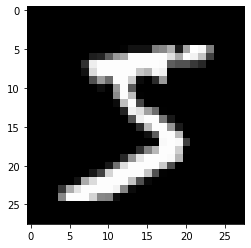

In [37]:
print('Original first image of dataset:')
display_digit(train_data[0])


Projection and Reconstruction for k = 100 dimensions:


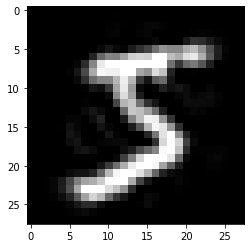


Projection and Reconstruction for k = 20 dimensions:


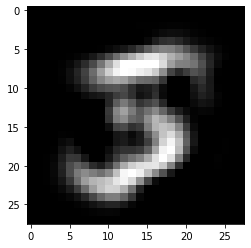


Projection and Reconstruction for k = 1 dimensions:


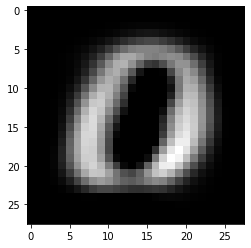

In [43]:
k_values = np.array([100, 20, 1])
for k in k_values:
    print('\nProjection and Reconstruction for k = {} dimensions:'.format(k))
    x_proj_rec = np.dot(projection_and_reconstruction(k), train_data[0])
    display_digit(x_proj_rec)

The images show, that a dimensionality reduction from 784 dimensions to 100 dimensions using PCA has no significant loss in information. This is remarkable, since it means the size of the **dataset can be reduced by 87% without significant loss in information.**

# 4. Building a k-nearest-neighbor classifier using PCA